<a href="https://colab.research.google.com/github/Markushenriksson13/Markushenriksson-AAUBDS-2024/blob/main/Assignment_3_(DONE).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cleaning and importing

Dataset: KIVA
Which countries show the highest demand for microloans, and how can loan allocation be optimized based on sectoral needs to maximize impact and efficiency?

Theory:
Countries with weaker economic infrastructures or greater population needs (such as developing countries) will exhibit higher demand for microloans, particularly in specific sectors like agriculture and food. By analyzing the loan amounts requested and funded across different sectors in various countries, it’s possible to identify patterns in demand and therefore maybe funding gaps. This information can be used to optimize loan allocation to sectors and countries that require more support or are more likely to generate economic returns by showcasing this for lenders.

To explore what lenders prefer to lend for, it can be analyzed by sectors, countries that attract the most lender engagement.



In [1]:
!pip install umap-learn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.3 MB/s eta 0:00:00


In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import umap
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import KMeans

sns.set()

In [3]:
# Clone repository from GitHub
!git clone https://github.com/aaubs/ds-master.git


Cloning into 'ds-master'...
remote: Enumerating objects: 3037, done.
remote: Counting objects: 100% (1317/1317), done.
remote: Compressing objects: 100% (504/504), done.
remote: Total 3037 (delta 975), reused 1097 (delta 807), pack-reused 1720 (from 1)
Receiving objects: 100% (3037/3037), 281.14 MiB | 12.87 MiB/s, done.
Resolving deltas: 100% (1770/1770), done.
Updating files: 100% (454/454), done.


In [4]:
import os

# Locate the correct filepath
os.chdir('/content/ds-master/data/assignments_datasets/KIVA')

# Check to see if the datasets are there
!ls



kiva_loans_part_0.csv.zip  kiva_loans_part_2.csv.zip	  loan_theme_ids.csv.zip
kiva_loans_part_1.csv.zip  kiva_mpi_region_locations.csv  loan_themes_by_region.csv


In [5]:
import zipfile

# Extract the zipfiles
with zipfile.ZipFile('kiva_loans_part_0.csv.zip', 'r') as zip_ref:
    zip_ref.extractall()
with zipfile.ZipFile('kiva_loans_part_1.csv.zip', 'r') as zip_ref:
    zip_ref.extractall()
with zipfile.ZipFile('kiva_loans_part_2.csv.zip', 'r') as zip_ref:
    zip_ref.extractall()
with zipfile.ZipFile('loan_theme_ids.csv.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [6]:
#Load them into pandas dataframes
df_part_0 = pd.read_csv('kiva_loans_part_0.csv')
df_part_1 = pd.read_csv('kiva_loans_part_1.csv')
df_part_2 = pd.read_csv('kiva_loans_part_2.csv')
df_mpi_region = pd.read_csv('kiva_mpi_region_locations.csv')
df_loan_theme_ids = pd.read_csv('loan_theme_ids.csv')
df_loan_themes_by_region = pd.read_csv('loan_themes_by_region.csv')

In [7]:
#Check if the columns makes sense
df_part_0.columns

Index(['id', 'funded_amount', 'loan_amount', 'activity', 'sector', 'use',
       'country_code', 'country', 'region', 'currency', 'partner_id',
       'posted_time', 'disbursed_time', 'funded_time', 'term_in_months',
       'lender_count', 'tags', 'borrower_genders', 'repayment_interval',
       'date'],
      dtype='object')

## 2. Data Cleaning and manipulation

In [8]:
#Concatonating the dataset
data = pd.concat([df_part_0, df_part_1, df_part_2])
#Using head to get an overview of the data
data.head()

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.0,12,NaN,female,irregular,2014-01-01
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,11.0,14,NaN,"female, female",irregular,2014-01-01
2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another ...,IN,India,Maynaguri,INR,334.0,2014-01-01 09:58:07+00:00,2013-12-17 08:00:00+00:00,2014-01-01 16:01:36+00:00,43.0,6,"user_favorite, user_favorite",female,bullet,2014-01-01
3,653063,200.0,200.0,Embroidery,Arts,to purchase an embroidery machine and a variet...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 08:03:11+00:00,2013-12-24 08:00:00+00:00,2014-01-01 13:00:00+00:00,11.0,8,NaN,female,irregular,2014-01-01
4,653084,400.0,400.0,Milk Sales,Food,to purchase one buffalo.,PK,Pakistan,Abdul Hakeem,PKR,245.0,2014-01-01 11:53:19+00:00,2013-12-17 08:00:00+00:00,2014-01-01 19:18:51+00:00,14.0,16,NaN,female,monthly,2014-01-01


In [9]:
data.shape

(671205, 20)

In [10]:
#Making sure they are dropped correctly
data.columns

Index(['id', 'funded_amount', 'loan_amount', 'activity', 'sector', 'use',
       'country_code', 'country', 'region', 'currency', 'partner_id',
       'posted_time', 'disbursed_time', 'funded_time', 'term_in_months',
       'lender_count', 'tags', 'borrower_genders', 'repayment_interval',
       'date'],
      dtype='object')

In [11]:
# Reshaping categorical variables into numerical variables
from sklearn.preprocessing import LabelEncoder

#Creatning incoder instance
encoder_activity = LabelEncoder()
encoder_sector = LabelEncoder()
encoder_genders = LabelEncoder()
encoder_country = LabelEncoder()
encoder_repayment = LabelEncoder()

# Transforming the columns
data['encoded_activity'] = encoder_activity.fit_transform(data['activity'])
data['encoded_sector'] = encoder_sector.fit_transform(data['sector'])
data['encoded_borrower_genders'] = encoder_genders.fit_transform(data['borrower_genders'])
data['encoded_country'] = encoder_country.fit_transform(data['country'])
data['encoded_repayment_interval'] = encoder_repayment.fit_transform(data['repayment_interval'])

# Checking Results
print(data[['activity', 'encoded_activity', 'sector', 'encoded_sector', 'borrower_genders', 'encoded_borrower_genders', 'country', 'encoded_country', 'repayment_interval', 'encoded_repayment_interval']].head())


              activity  encoded_activity          sector  encoded_sector  \
0  Fruits & Vegetables                67            Food               6   
1             Rickshaw               134  Transportation              13   
2       Transportation               148  Transportation              13   
3           Embroidery                52            Arts               1   
4           Milk Sales                95            Food               6   

  borrower_genders  encoded_borrower_genders   country  encoded_country  \
0           female                         0  Pakistan               54   
1   female, female                         1  Pakistan               54   
2           female                         0     India               29   
3           female                         0  Pakistan               54   
4           female                         0  Pakistan               54   

  repayment_interval  encoded_repayment_interval  
0          irregular                     

In [12]:
#Dropping columns that are not needed
data_cleaned = data.drop(['use', 'region', 'currency', 'id', 'partner_id', 'posted_time', 'disbursed_time', 'funded_time', 'tags', 'country_code', 'region', 'date', 'activity', 'sector', 'borrower_genders', 'country', 'repayment_interval'], axis=1)

In [13]:
data_cleaned.head()

,funded_amount,loan_amount,term_in_months,lender_count,encoded_activity,encoded_sector,encoded_borrower_genders,encoded_country,encoded_repayment_interval
0,300.0,300.0,12.0,12,67,6,0,54,1
1,575.0,575.0,11.0,14,134,13,1,54,1
2,150.0,150.0,43.0,6,148,13,0,29,0
3,200.0,200.0,11.0,8,52,1,0,54,1
4,400.0,400.0,14.0,16,95,6,0,54,2


In [14]:
#Getting overall info on the data
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 671205 entries, 0 to 221204
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   funded_amount               671205 non-null  float64
 1   loan_amount                 671205 non-null  float64
 2   term_in_months              671205 non-null  float64
 3   lender_count                671205 non-null  int64  
 4   encoded_activity            671205 non-null  int64  
 5   encoded_sector              671205 non-null  int64  
 6   encoded_borrower_genders    671205 non-null  int64  
 7   encoded_country             671205 non-null  int64  
 8   encoded_repayment_interval  671205 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 51.2 MB


In [15]:
#Dropping missing values
data_cleaned.dropna()

,funded_amount,loan_amount,term_in_months,lender_count,encoded_activity,encoded_sector,encoded_borrower_genders,encoded_country,encoded_repayment_interval
0,300.0,300.0,12.0,12,67,6,0,54,1
1,575.0,575.0,11.0,14,134,13,1,54,1
2,150.0,150.0,43.0,6,148,13,0,29,0
3,200.0,200.0,11.0,8,52,1,0,54,1
4,400.0,400.0,14.0,16,95,6,0,54,2
...,...,...,...,...,...,...,...,...,...
221200,0.0,25.0,13.0,0,89,0,0,57,2
221201,25.0,25.0,13.0,1,89,0,0,34,2
221202,0.0,25.0,13.0,0,71,5,11298,34,2
221203,0.0,25.0,13.0,0,89,0,0,34,2


In [16]:
#Checking if they are removed
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 671205 entries, 0 to 221204
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   funded_amount               671205 non-null  float64
 1   loan_amount                 671205 non-null  float64
 2   term_in_months              671205 non-null  float64
 3   lender_count                671205 non-null  int64  
 4   encoded_activity            671205 non-null  int64  
 5   encoded_sector              671205 non-null  int64  
 6   encoded_borrower_genders    671205 non-null  int64  
 7   encoded_country             671205 non-null  int64  
 8   encoded_repayment_interval  671205 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 51.2 MB


In [17]:
#Making a sample, as the dataframe is too large to perform this UML proces
data_cleaned = data_cleaned.sample(n=5000)


In [18]:
data_cleaned.head()

,funded_amount,loan_amount,term_in_months,lender_count,encoded_activity,encoded_sector,encoded_borrower_genders,encoded_country,encoded_repayment_interval
34920,2000.0,2000.0,14.0,66,26,3,6904,38,2
100418,250.0,250.0,35.0,9,1,0,0,34,1
2472,925.0,925.0,10.0,15,57,0,10686,34,0
170352,950.0,950.0,8.0,34,89,0,3488,9,1
71108,50.0,50.0,13.0,2,112,8,0,30,1


In [19]:
# Also making a sample of the non-converted df with categorical varibes
data_sampled = data.sample(n=5000)

In [20]:
data_sampled.head()

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,...,lender_count,tags,borrower_genders,repayment_interval,date,encoded_activity,encoded_sector,encoded_borrower_genders,encoded_country,encoded_repayment_interval
43239,915383,200.0,600.0,Personal Housing Expenses,Housing,"to invest in brick, cement, sand, etc.",SV,El Salvador,NaN,USD,...,8,"#Health and Sanitation, #Parent, #Repeat Borrower",female,monthly,2015-07-09,112,8,0,22,2
190510,1062368,675.0,675.0,Agriculture,Agriculture,"to buy organic manure, urea, fertilizers, seed...",HN,Honduras,San Lorenzo,HNL,...,25,"#Parent, #Sustainable Ag, #Vegan",male,irregular,2016-04-28,1,0,6904,28,1
202587,1315584,150.0,150.0,Furniture Making,Manufacturing,to purchase more wood and fabric materials for...,KE,Kenya,Kitale,KES,...,6,"#Fabrics, #Parent",male,monthly,2017-06-07,70,9,6904,34,2
43885,696615,200.0,200.0,Higher education costs,Education,to pay for her university tuition fee,KH,Cambodia,"Phnom Penh, Steung Meanchey district",USD,...,8,"#Schooling, #Parent, user_favorite",female,monthly,2014-04-11,77,4,0,11,2
85680,737604,1000.0,1000.0,Farming,Agriculture,to buy fertilizer and seeds for her farmland,KH,Cambodia,"Battambang province, Moung Russey district",KHR,...,31,"#Elderly, #Single Parent, #Woman Owned Biz","female, female",monthly,2014-07-11,57,0,1,11,2


# Preproces for UML (normalization & feature selection)

In [21]:
#Locating the only variables that are needed for the proces
data_to_cluster = data_cleaned.iloc[:, :9]


In [22]:
data_to_cluster.head()

,funded_amount,loan_amount,term_in_months,lender_count,encoded_activity,encoded_sector,encoded_borrower_genders,encoded_country,encoded_repayment_interval
34920,2000.0,2000.0,14.0,66,26,3,6904,38,2
100418,250.0,250.0,35.0,9,1,0,0,34,1
2472,925.0,925.0,10.0,15,57,0,10686,34,0
170352,950.0,950.0,8.0,34,89,0,3488,9,1
71108,50.0,50.0,13.0,2,112,8,0,30,1


In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [24]:
# learn x-y relationships (principal components) and transform
# Scaling the data (prep)
data_to_cluster_scaled = scaler.fit_transform(data_to_cluster)

In [25]:

from sklearn.preprocessing import MinMaxScaler
scaler_min_max = MinMaxScaler()

In [26]:
data_to_cluster_minmax = scaler_min_max.fit_transform(data_to_cluster)

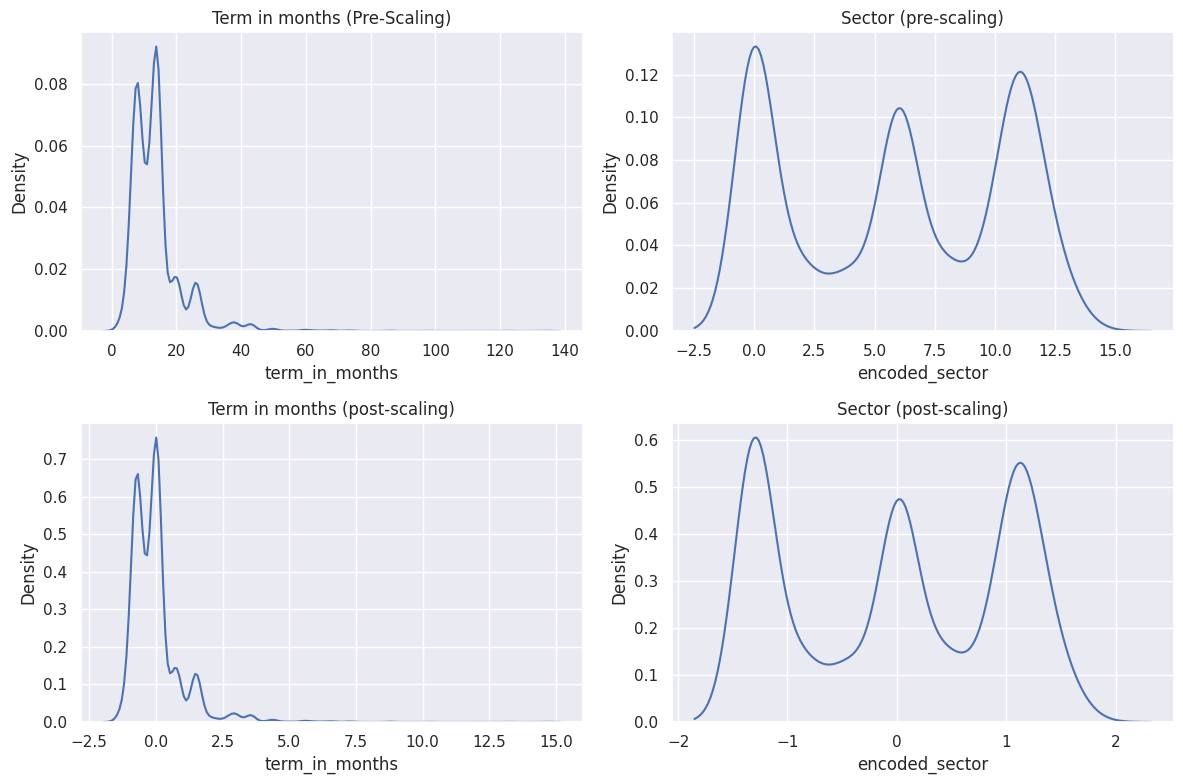

In [83]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Term in months (pre-scaling)
sns.kdeplot(data=data_to_cluster, x="term_in_months", ax=axes[0, 0])
axes[0, 0].set_title("Term in months (Pre-Scaling)")

# Sector (pre-scaling)
sns.kdeplot(data=data_to_cluster, x="encoded_sector", ax=axes[0, 1])
axes[0, 1].set_title("Sector (pre-scaling)")

# convert scaled data to dataframe
scaled_df = pd.DataFrame(data_to_cluster_scaled, columns=data_to_cluster.columns)

# Term in months (post-scaling)
sns.kdeplot(data=scaled_df, x="term_in_months", ax=axes[1, 0])
axes[1, 0].set_title("Term in months (post-scaling)")

# Sector (post-scaling)
sns.kdeplot(data=scaled_df, x="encoded_sector", ax=axes[1, 1])
axes[1, 1].set_title("Sector (post-scaling)")

plt.tight_layout()
plt.show()

# Dimensionality reduction

# PCA (Reduction)

In [28]:
# load up and instantiate PCA
pca = PCA(n_components=2)

In [29]:
# Transform the data
data_reduced_pca = pca.fit_transform(data_to_cluster_scaled)
pca.components_.shape

(2, 9)

In [30]:
# How much information is lost?
print(pca.explained_variance_ratio_)

[0.30485446 0.16322324]


<Axes: >

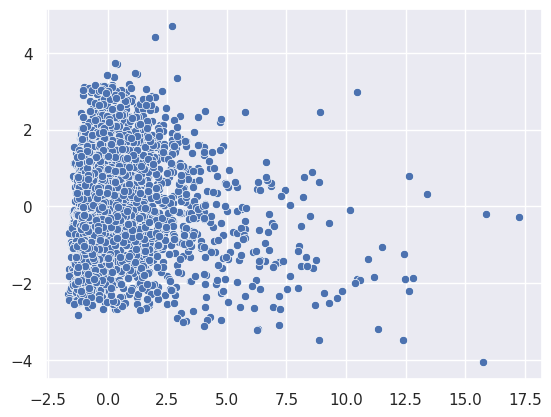

In [31]:
sns.scatterplot(x=data_reduced_pca[:,0], y=data_reduced_pca[:,1])

In [32]:
# Create a new DataFrame based on the reduced data from PCA
vis_data = pd.DataFrame(data_reduced_pca)

# Add 'sector' column from the original 'data' DataFrame to 'vis_data'
# Reset the index of both DataFrames to ensure alignment and avoid potential conflicts from duplicate indices
vis_data['sector'] = data.reset_index()['sector']

# Add 'country' column, represented by its alpha-2 code, from the original 'data' DataFrame to 'vis_data'
vis_data['country'] = data.reset_index()['country']


# Rename the columns of 'vis_data' for better clarity:
# The first two columns represent the two principal components from PCA
# The third and fourth columns are 'place' and 'country' respectively
vis_data.columns = ['x', 'y', 'sector', 'country']

# Using the Altair library to create an interactive scatter plot:
# - The x and y axes represent the two principal components.
# - Each data point (or circle) in the scatter plot corresponds to a 'place' in a 'country'.
# - Hovering over a data point reveals a tooltip with the 'place' and 'country' information.
alt.Chart(vis_data).mark_circle(size=60).encode(
    x='x',          # Set the x-axis to represent the first principal component
    y='y',          # Set the y-axis to represent the second principal component
    tooltip=['sector', 'country']  # Display 'place' and 'country' information as a tooltip on hover
).interactive()   # Enable interactive features such as panning and zooming


/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

<Axes: >

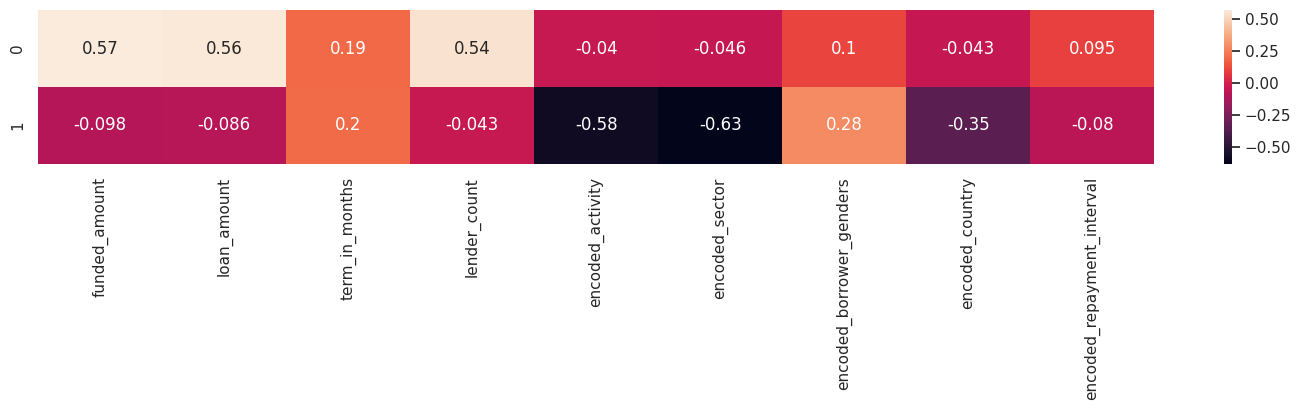

In [33]:
plt.figure(figsize=(18,2))
sns.heatmap(pd.DataFrame(pca.components_, columns=data_to_cluster.columns), annot=True)

<Axes: >

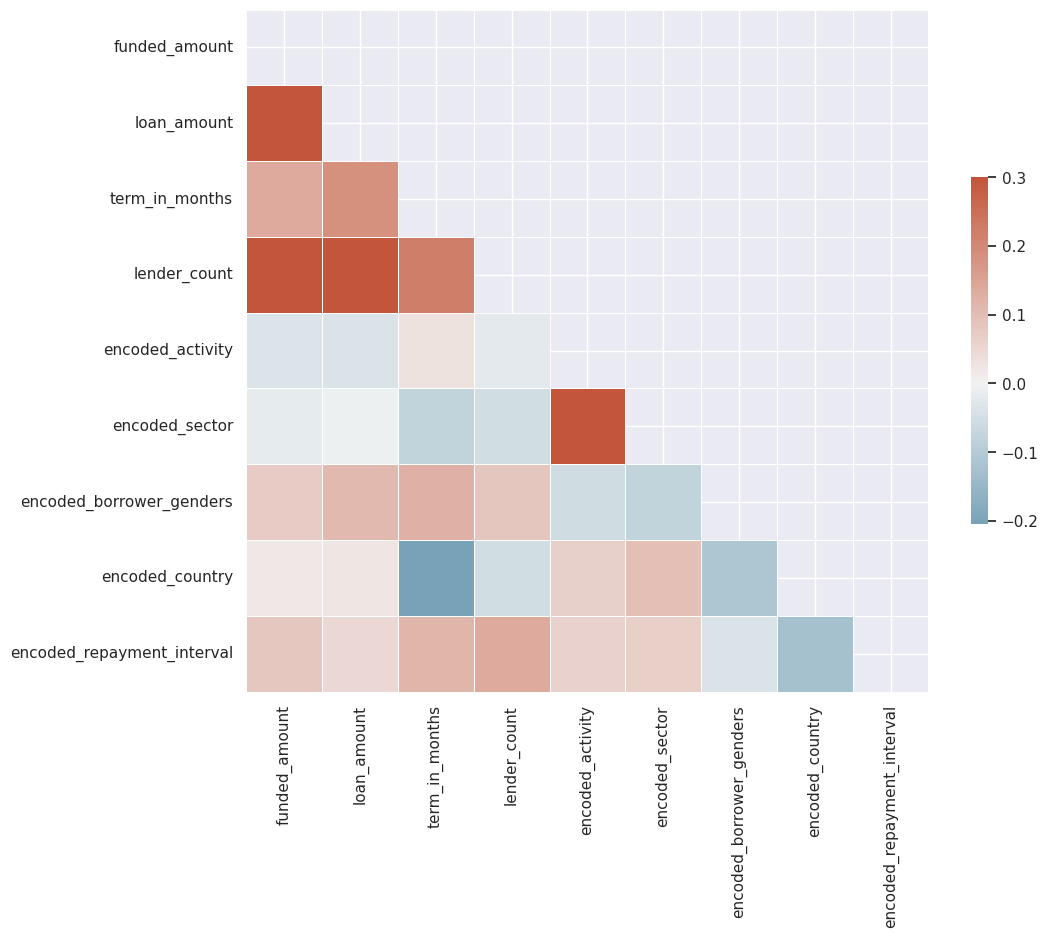

In [34]:
#Correlation between variables

# Compute the correlation matrix
corr = data_to_cluster.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# NMF (Reduction)

In [35]:
# import nmf
from sklearn.decomposition import NMF

In [36]:
# instantiate with 4 components
nmf = NMF(n_components=4)

In [37]:
# Using the min-max scaled data
data_reduced_nmf = nmf.fit_transform(data_to_cluster_minmax)

In [85]:
#Showing off the initial shape
data_to_cluster_minmax.shape

(5000, 9)

In [38]:
data_reduced_nmf.shape

(5000, 4)

In [39]:
#Checking the components of the nmf
nmf.components_.shape

(4, 9)

<Axes: >

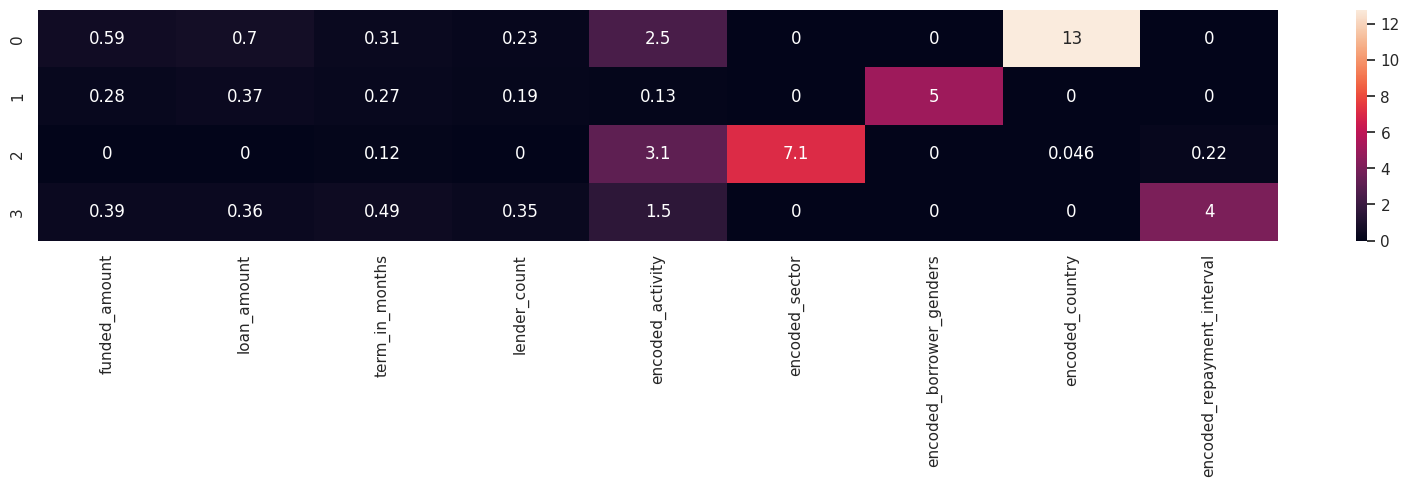

In [84]:
#The 4 datapoints and their correlation with the actual ones
plt.figure(figsize=(20,3))
sns.heatmap(pd.DataFrame(nmf.components_, columns=data_to_cluster.columns), annot=True)

# UMAP (Reduction)

In [41]:

umap_scaler = umap.UMAP()

In [42]:
# Creating embeddings
embeddings = umap_scaler.fit_transform(data_to_cluster_scaled)

<Axes: >

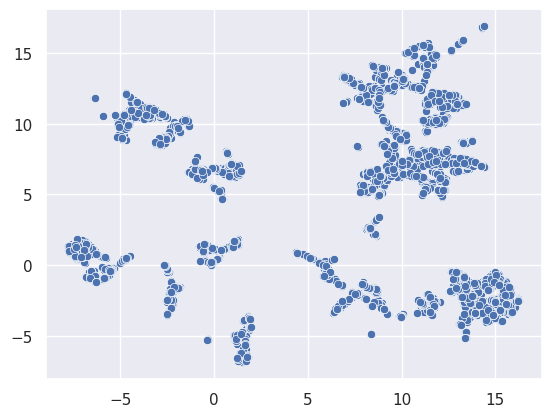

In [43]:
# Plotting the UMAP
sns.scatterplot(x=embeddings[:,0], y=embeddings[:,1])

In [44]:
# Construct a new DataFrame from the embeddings and merge with 'country' columns from the original data
vis_data = pd.DataFrame({
    'x': embeddings[:, 0],         # Assuming embeddings is a 2D array or similar structure
    'y': embeddings[:, 1],
    'country': data_sampled['country']
})

# Create an interactive scatter plot using Altair
chart = alt.Chart(vis_data).mark_circle(size=60).encode(
    x='x',
    y='y',
    tooltip=['country']
).interactive()

chart

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

# K Clustering

In [45]:
max_iters=100
k = 3

In [46]:
# 1. Initialize the k cluster centroids
centroids = data_reduced_pca[np.random.choice(data_sampled.shape[0], k, replace=False)] # Use data_reduced_pca.shape[0] to get the correct number of samples

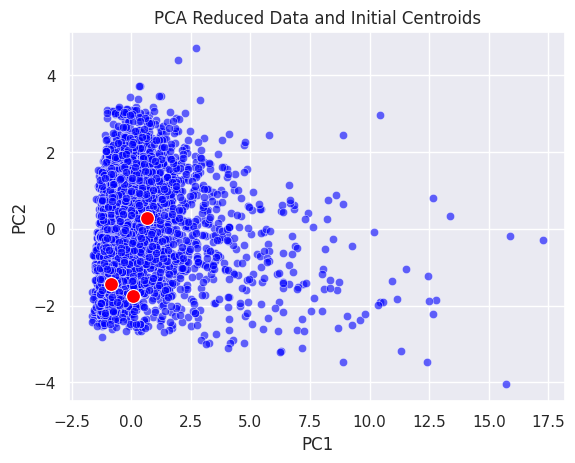

In [47]:
# Plot observations
sns.scatterplot(x=data_reduced_pca[:, 0], y=data_reduced_pca[:, 1], alpha=0.6, color='blue')

# Plot centroids
sns.scatterplot(x=centroids[:, 0], y=centroids[:, 1], color='red', s=100)

plt.title('PCA Reduced Data and Initial Centroids')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [48]:
# 2. Assign each data point to the closest centroid
distances = np.linalg.norm(data_reduced_pca - centroids[:, np.newaxis], axis=2)
labels = np.argmin(distances, axis=0)

In [49]:
# 3. Recompute the centroids
new_centroids = np.array([data_reduced_pca[labels == i].mean(axis=0) for i in range(k)])

In [50]:
new_centroids

array([[ 0.53805046,  0.76828973],
       [-0.95658457, -0.78987473],
       [ 0.80615585, -1.64531875]])

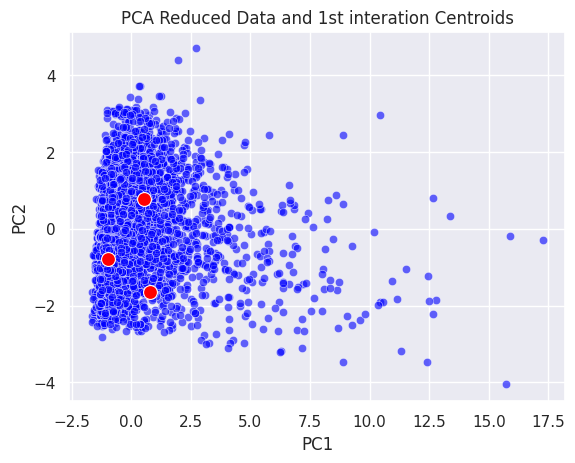

In [51]:
# Plot observations after 1st interation
sns.scatterplot(x=data_reduced_pca[:, 0], y=data_reduced_pca[:, 1], alpha=0.6, color='blue')

# Plot centroids
sns.scatterplot(x=new_centroids[:, 0], y=new_centroids[:, 1], color='red', s=100)

plt.title('PCA Reduced Data and 1st interation Centroids')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [52]:
# A simple implementation of K-means
# Iterating the proces 100 times

def k_means_simple(data, k, max_iters=100):
    # 1. Initialize the k cluster centroids
    centroids = data[np.random.choice(data.shape[0], k, replace=False)]

    for _ in range(max_iters):
        # 2. Assign each data point to the closest centroid
        distances = np.linalg.norm(data - centroids[:, np.newaxis], axis=2)
        labels = np.argmin(distances, axis=0)

        # 3. Recompute the centroids
        new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)])

        # Check for convergence
        if np.all(centroids == new_centroids):
            break

        centroids = new_centroids

    return labels, centroids

In [53]:
# Testing the simple k-means
# Finding final centroids from function above
labels, final_centroids = k_means_simple(data_reduced_pca, 3)
print("Cluster centroids:\n", final_centroids)

Cluster centroids:
 [[-0.59979914 -0.75036061]
 [ 0.07773164  1.20322536]
 [ 5.0151499  -0.6637994 ]]


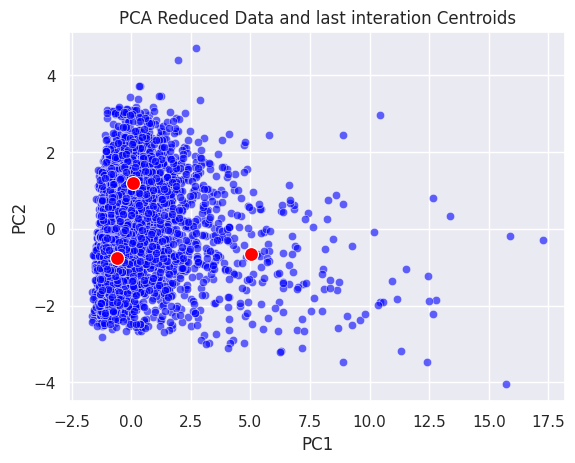

In [86]:
# Ploting after 100 iterations
sns.scatterplot(x=data_reduced_pca[:, 0], y=data_reduced_pca[:, 1], alpha=0.6, color='blue')

# Plot centroids
sns.scatterplot(x=final_centroids[:, 0], y=final_centroids[:, 1], color='red', s=100)

plt.title('PCA Reduced Data and last interation Centroids')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [87]:
#Pre-defining clusters, usually after performing Elbow Method
#clusterer = KMeans(n_clusters=3)

In [88]:
# Initializing an empty list to store the sum of squared distances for each 'k'
Sum_of_squared_distances = []

# Define a range for possible cluster values (1 to 9)
K = range(1, 10)

# For each possible 'k', fit a KMeans model and compute the sum of squared distances
for k in K:
    km = KMeans(n_clusters=k, n_init = "auto")               # Initialize the KMeans model with 'k' clusters
    km.fit(data_to_cluster_scaled)          # Fit the model on the scaled data
    Sum_of_squared_distances.append(km.inertia_)  # Append the model's inertia (sum of squared distances) to the list

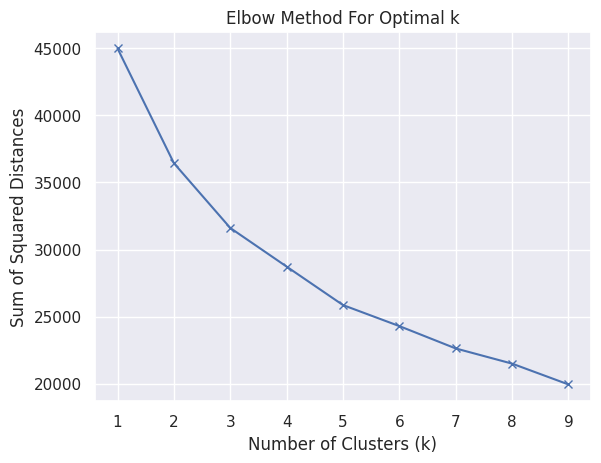

In [89]:
# Plot the sum of squared distances for each 'k' to determine the 'elbow'
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.grid(True)  # Add a grid for better visualization
plt.show()

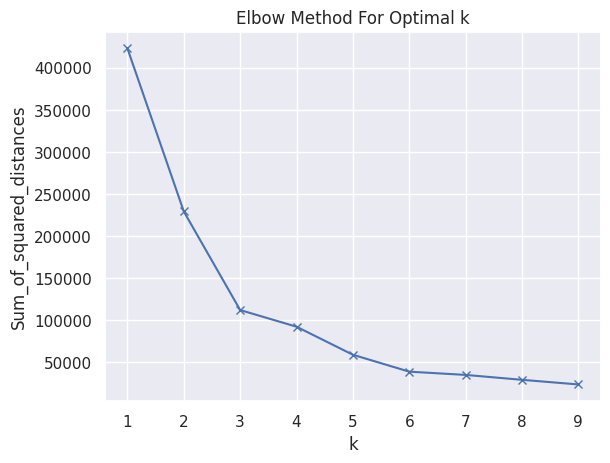

In [90]:
umap_scaler_km = umap.UMAP(n_components=6)
embeddings_km = umap_scaler.fit_transform(data_to_cluster_scaled)


Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k, n_init = "auto")
    km = km.fit(embeddings_km)
    Sum_of_squared_distances.append(km.inertia_)


plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [115]:
# As shown in elbow method, 3 clusters are optimal for our data
clusterer = KMeans(n_clusters=3)

In [116]:

clusterer.fit(data_to_cluster_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3)

In [117]:
# Copy the cluster-numbers into the original file
data_sampled['cluster'] = clusterer.labels_

In [118]:
#Irrelevant
data_sampled.groupby('cluster').encoded_sector.mean()

,encoded_sector
cluster,
0,5.800571
1,6.105512
2,5.952055


In [95]:
# Preparing for plot
# Reset the index of data_sampled
data_sampled = data_sampled.reset_index()

vis_data = pd.DataFrame(embeddings)
vis_data['country'] = data_sampled['country']
vis_data['cluster'] = data_sampled['cluster']
vis_data['sector'] = data_sampled['sector']
vis_data.columns = ['x', 'y', 'place', 'cluster','country']

In [96]:
#visualization
# UMAP chart
alt.Chart(vis_data).mark_circle(size=60).encode(
    x='x',
    y='y',
    tooltip=['place', 'country'],
    color=alt.Color('cluster:N', scale=alt.Scale(scheme='set1')) #use N after the var to tell altair that it's categorical
).interactive()

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

# Hierarical clustering

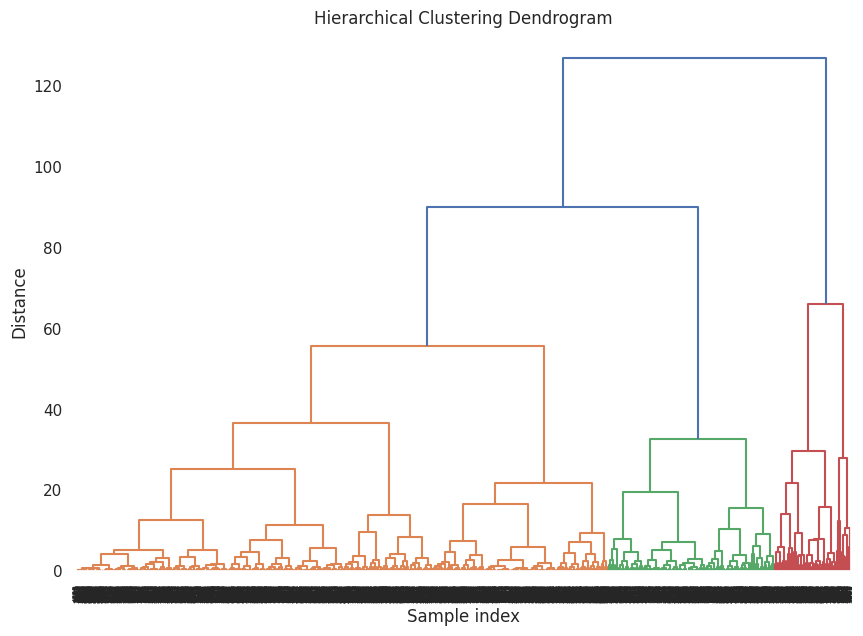

In [97]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt


linked = linkage(data_reduced_pca, 'ward')


plt.figure(figsize=(10, 7))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()


In [98]:
from scipy.cluster.hierarchy import fcluster

# Defining
k = 3  # 3 clusters as conducted by elbow
cluster_labels = fcluster(linked, k, criterion='maxclust')


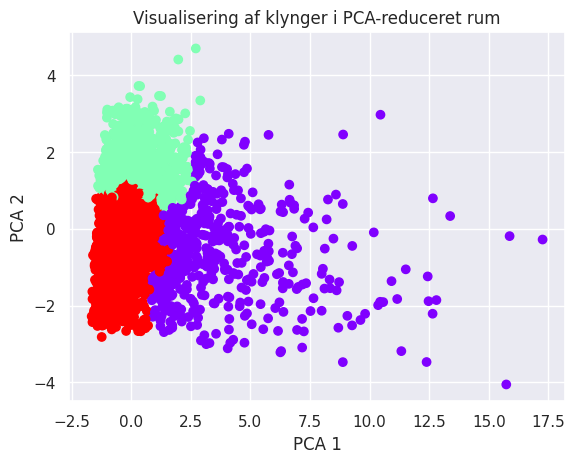

In [99]:
# Building the clusters around PCA
plt.scatter(data_reduced_pca[:, 0], data_reduced_pca[:, 1], c=cluster_labels, cmap='rainbow')
plt.title('Visualisering af klynger i PCA-reduceret rum')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()


# Recommendation machine

In [163]:
#Using these datapoints


print(data_reduced_nmf[0,:])
print(data_reduced_nmf[1,:])

[0.03144954 0.12255188 0.01701165 0.14923205]
[0.02790215 0.00064711 0.         0.07127317]


In [162]:
# Example with np
np.linalg.norm(data_reduced_nmf[0,:] - data_reduced_nmf[1,:])

0.14574066284249293

In [156]:
import math

In [157]:
from sklearn.metrics.pairwise import euclidean_distances

In [158]:
euclidean_matrix = euclidean_distances(data_reduced_nmf)
euclidean_matrix.shape

(5000, 5000)

In [159]:
#Finding the indexes for the 3 datapoints the closest to index 0 (1. datapoint)
np.argsort(euclidean_matrix[0,:])[:3]

array([   0, 2668,  170])

In [160]:
data_sampled[
    (data_sampled['country'] == 'Colombia') &
    (data_sampled['sector'] == 'Services') &
    (data_sampled['activity'] == 'Beauty Salon')
]




,level_0,index,id,funded_amount,loan_amount,activity,sector,use,country_code,country,...,tags,borrower_genders,repayment_interval,date,encoded_activity,encoded_sector,encoded_borrower_genders,encoded_country,encoded_repayment_interval,cluster
43,43,113462,1224145,300.0,300.0,Beauty Salon,Services,"to buy equipment and beauty products: dyes, hy...",CO,Colombia,...,"user_favorite, #Woman Owned Biz",female,monthly,2017-01-21,10,12,0,15,2,0
1705,1705,125817,997525,450.0,450.0,Beauty Salon,Services,buy some supplies like a chair to sit and give...,CO,Colombia,...,"#Parent, #Biz Durable Asset",male,bullet,2015-12-19,10,12,6904,15,0,0
2784,2784,89245,741206,1125.0,1125.0,Beauty Salon,Services,"to buy components to start her own business, l...",CO,Colombia,...,"volunteer_like, #Biz Durable Asset",female,monthly,2014-07-18,10,12,0,15,2,2
4581,4581,37016,909230,250.0,250.0,Beauty Salon,Services,to buy supplies. She also wants to sell produc...,CO,Colombia,...,"#Woman Owned Biz, #Parent, user_favorite",female,bullet,2015-06-26,10,12,0,15,0,0


In [161]:
#The datapoints that are the closest to index number x
ixs = np.argsort(euclidean_matrix[43,:])[:10]
print(data_sampled['country'][ixs])

43         Colombia
1840        Vietnam
3201         Uganda
4462       Cambodia
1818       Colombia
1180          Kenya
3479    Philippines
4720       Pakistan
3941      Nicaragua
4727           Peru
Name: country, dtype: object


In [164]:
#Finding the first datapoint that has a specific sector in it and then returning the datapoints which has the cloest euclidean distance to this point
def recommender_sector(sector, n_recs):
  if sector in list(set(data_sampled.sector)):
    ix = data_sampled[data_sampled['sector']==sector].index[0]
    ixs = np.argsort(euclidean_matrix[ix,:])[1:n_recs+1:]
    return data_sampled['sector'][ixs]
  else:
    return 'Place not in the dataset'

In [166]:
recommender_sector('Food', 9)

,sector
3501,Housing
4397,Agriculture
1199,Retail
2850,Agriculture
3964,Retail
3949,Personal Use
413,Education
4756,Housing
4735,Education


In [177]:
def recommender(sector, country, activity, n_recs=1, method='median'):
    # Starter med det mest specifikke filter
    filters = [
        (data_sampled['sector'] == sector) & (data_sampled['country'] == country) & (data_sampled['activity'] == activity),
        (data_sampled['sector'] == sector) & (data_sampled['country'] == country),
        (data_sampled['sector'] == sector)
    ]

    for filter in filters:
        filtered_data = data_sampled[filter]
        if len(filtered_data) >= n_recs:
            if method == 'median':
                return filtered_data['loan_amount'].median()
            else:
                return filtered_data['loan_amount'].mean()

    return "Ikke nok data til at give anbefalinger."
print(recommender('Food', 'Kenya', 'Farming', 10))


275.0


In [168]:


def recommender(sector, country, n_recs=1, method='median'):
    # Filtrer datarammen baseret på 'sector' og 'country'
    filtered_data = data_sampled[
        (data_sampled['sector'] == sector) &
        (data_sampled['country'] == country)
    ]

    # Tjek om der er tilstrækkelige data efter filtrering
    if len(filtered_data) < n_recs:
        return "Ikke nok data til at give anbefalinger."

    # Beregn anbefalet lånebeløb baseret på den angivne metode (median eller mean)
    if method == 'median':
        recommended_amount = filtered_data['loan_amount'].median()
    else:
        recommended_amount = filtered_data['loan_amount'].mean()

    return recommended_amount

# Eksempel på anvendelse af funktionen
print(recommender('Agriculture', 'Kenya', 10, method='median'))

400.0


In [130]:
# Install and import of gradio
!pip install gradio -q
import gradio as gr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 2.9 MB/s eta 0:00:00


In [175]:
demo = gr.Interface(
    fn=recommender,
    inputs=[
        gr.Dropdown(data_cleaned['encoded_sector'].tolist(), label="Sector I like!", info="Pick one!"),
        gr.Dropdown(data_cleaned['encoded_country'].tolist(), label="Country I like!", info="Pick one!"),
        gr.Dropdown(data_cleaned['encoded_activity'].tolist(), label="Activity I like!", info="Pick one!"),
        gr.Slider(1, 15, 5, step=1, label="Number of recommendations")
    ],
    outputs="text"
)

In [176]:
# Run it!!!
demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://36e4342febab148a11.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
